In [1]:
import os
from typing import List, Optional

from umap import UMAP
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import colorcet as cc


from cuml.cluster import KMeans as cuKMeans
from sklearn.cluster import KMeans


def load_result(dir_path, ensemble_size=5, skip=None):
    if skip is None:
        skip = []
    elif isinstance(skip, int):
        skip = [skip]
    pred_res_list = []
    for i in range(ensemble_size):
        if i+1 in skip:
            continue
        pred_res_path = dir_path + f"final_result_{i+1}.csv"
        print("loading", pred_res_path)
        pred_res = pd.read_csv(pred_res_path)
        # change pred_result to pred_result_1, pred_result_2, ...
        pred_res.columns = [f"{col}_{i+1}" if col != "smi_name" else col for col in pred_res.columns]
        pred_res_list.append(pred_res)
    return pred_res_list
        


embedding_dir = "/home/sdl/SDL-LNP/model/evaluation/notebooks/"
data_dir = "/home/sdl/SDL-LNP/model/serverless/test/"
tested_smiles_file = "/home/sdl/control_dashboard/info_server/SDL-LNP/model/evaluation/notebooks/exp1030_export.csv"  # NOTE: change this to the newest file
print("Existing tested smiles in", tested_smiles_file)


embeddings_path = embedding_dir + "test_result_representation.npz"


pred_res_list = load_result(data_dir)
pred_res = pd.concat(pred_res_list, axis=1, join="outer")
with np.load(embeddings_path) as data:
    embeddings = data["arr_0"]
    
# keep only one smi_name column
pred_res = pred_res.loc[:, ~pred_res.columns.duplicated()]
mean_pred_res = pred_res.groupby("smi_name").mean()
# get mean embedding with same smi_name
smi_names = pred_res["smi_name"].unique()
embeddings_df = pd.DataFrame(embeddings, index=pred_res["smi_name"])
# mean_embeddings = embeddings_df.groupby("smi_name").mean()

# get first embedding with same smi_name
mean_embeddings = embeddings_df.groupby("smi_name").first()

MAPPING_PATH = "/home/sdl/SDL-LNP/model/data_process/220k_library.csv"
mapping_df = pd.read_csv(MAPPING_PATH)
NAME_SMI_PATH = "/home/sdl/SDL-LNP/mapping_table/General_mapping_sampler.csv"
name_smi_df = pd.read_csv(NAME_SMI_PATH)


mapping_df["A_name"] = mapping_df["A_smiles"].map(name_smi_df.set_index('Reagent SMILES')['Reagent Name'])
mapping_df["B_name"] = mapping_df["B_smiles"].map(name_smi_df.set_index('Reagent SMILES')['Reagent Name'])
mapping_df["C_name"] = mapping_df["C_smiles"].map(name_smi_df.set_index('Reagent SMILES')['Reagent Name'])
mapping_df["D_name"] = mapping_df["D_smiles"].map(name_smi_df.set_index('Reagent SMILES')['Reagent Name'])


mean_pred_res = pred_res.groupby("smi_name").mean()  # mean over different conformations
# get mean embedding with same smi_name
smi_names = pred_res["smi_name"].unique()
embeddings_df = pd.DataFrame(embeddings, index=pred_res["smi_name"])
# mean_embeddings = embeddings_df.groupby("smi_name").mean()

# get first embedding with same smi_name
mean_embeddings = embeddings_df.groupby("smi_name").first()


Existing tested smiles in /home/sdl/control_dashboard/info_server/SDL-LNP/model/evaluation/notebooks/exp1030_export.csv
loading /home/sdl/SDL-LNP/model/serverless/test/final_result_1.csv
loading /home/sdl/SDL-LNP/model/serverless/test/final_result_2.csv
loading /home/sdl/SDL-LNP/model/serverless/test/final_result_3.csv
loading /home/sdl/SDL-LNP/model/serverless/test/final_result_4.csv
loading /home/sdl/SDL-LNP/model/serverless/test/final_result_5.csv


In [2]:
# read in already tested smiles from existing experiment results
# will ensure new candidates proposed are not duplicates
tested_smiles = pd.read_csv(tested_smiles_file)["smiles"].values.tolist()
print("Number of already tested smiles:", len(tested_smiles))

Number of already tested smiles: 1469


# step 1

In [3]:
predictive_variance = mean_pred_res.var(axis=1)

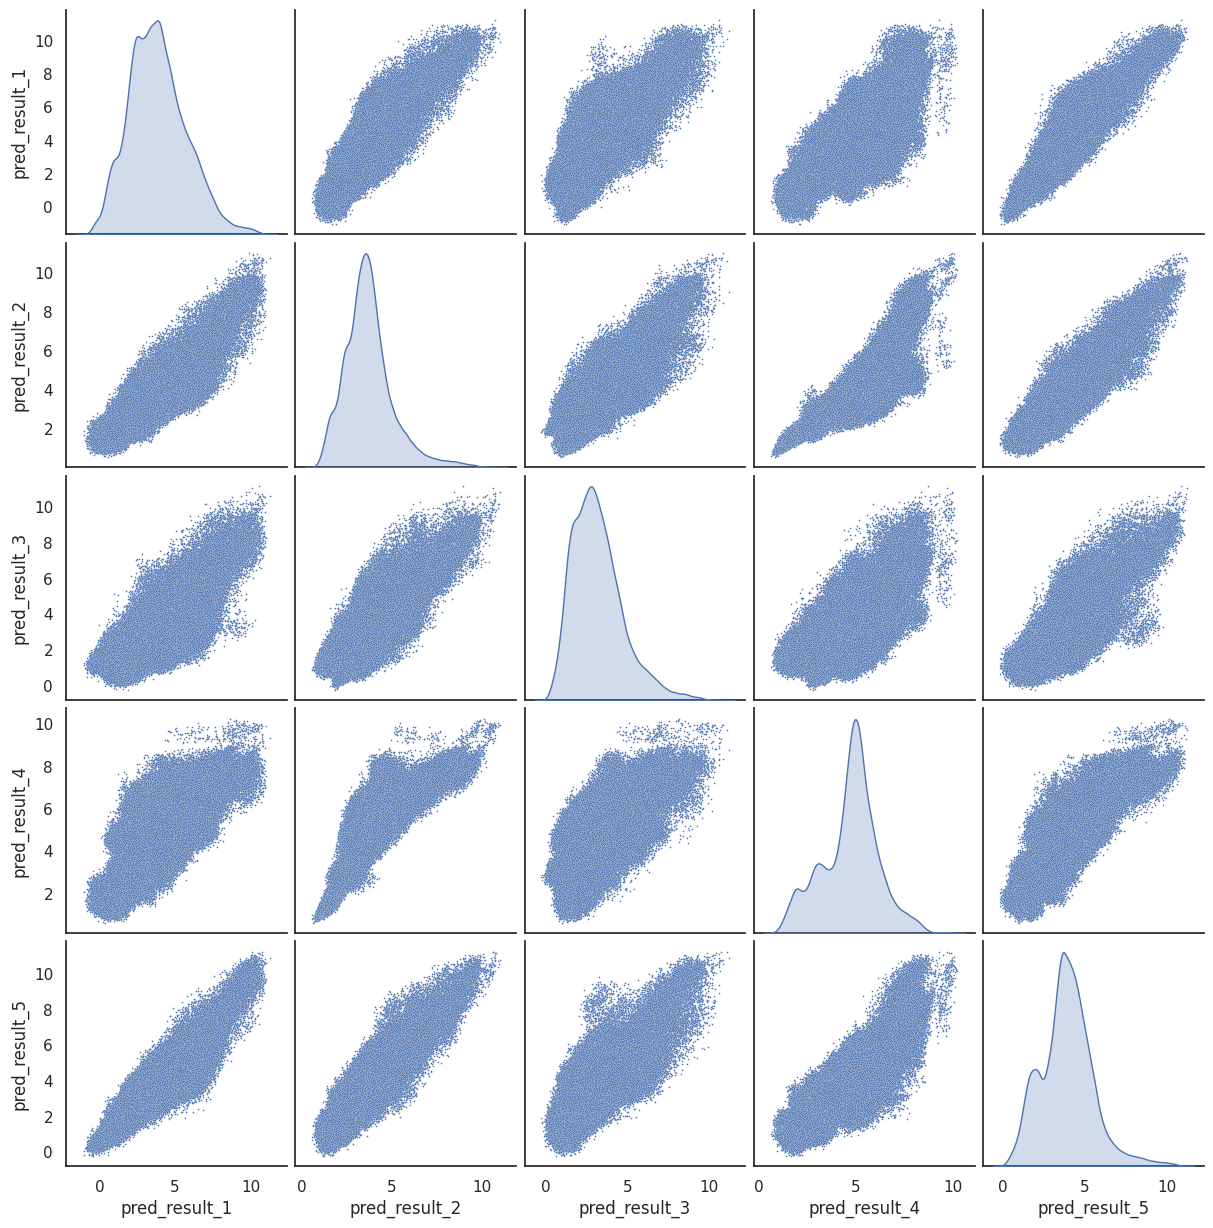

In [4]:
# plot grid of df
sns.set_theme(style="white")
df = mean_pred_res
sns.pairplot(df, diag_kind="kde", plot_kws={"s": 1.5})

In [5]:
def count_components(structures):
    res_list = []
    # structures is a list of smiles
    idx = mapping_df.index[mapping_df["combined_mol_SMILES"].isin(structures)].tolist()
    A = mapping_df.loc[idx, "A_name"]
    B = mapping_df.loc[idx, "B_name"]
    C = mapping_df.loc[idx, "C_name"]
    D = mapping_df.loc[idx, "D_name"]
    res_list.extend(A)
    res_list.extend(B)
    res_list.extend(C)
    res_list.extend(D)
    # count table for each unique A or unqiue B or unique C or unique D
    count_table = pd.DataFrame(res_list, columns=["reagent_name"]).value_counts().reset_index()
    return res_list, count_table

/home/sdl/miniconda3/envs/unimol/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


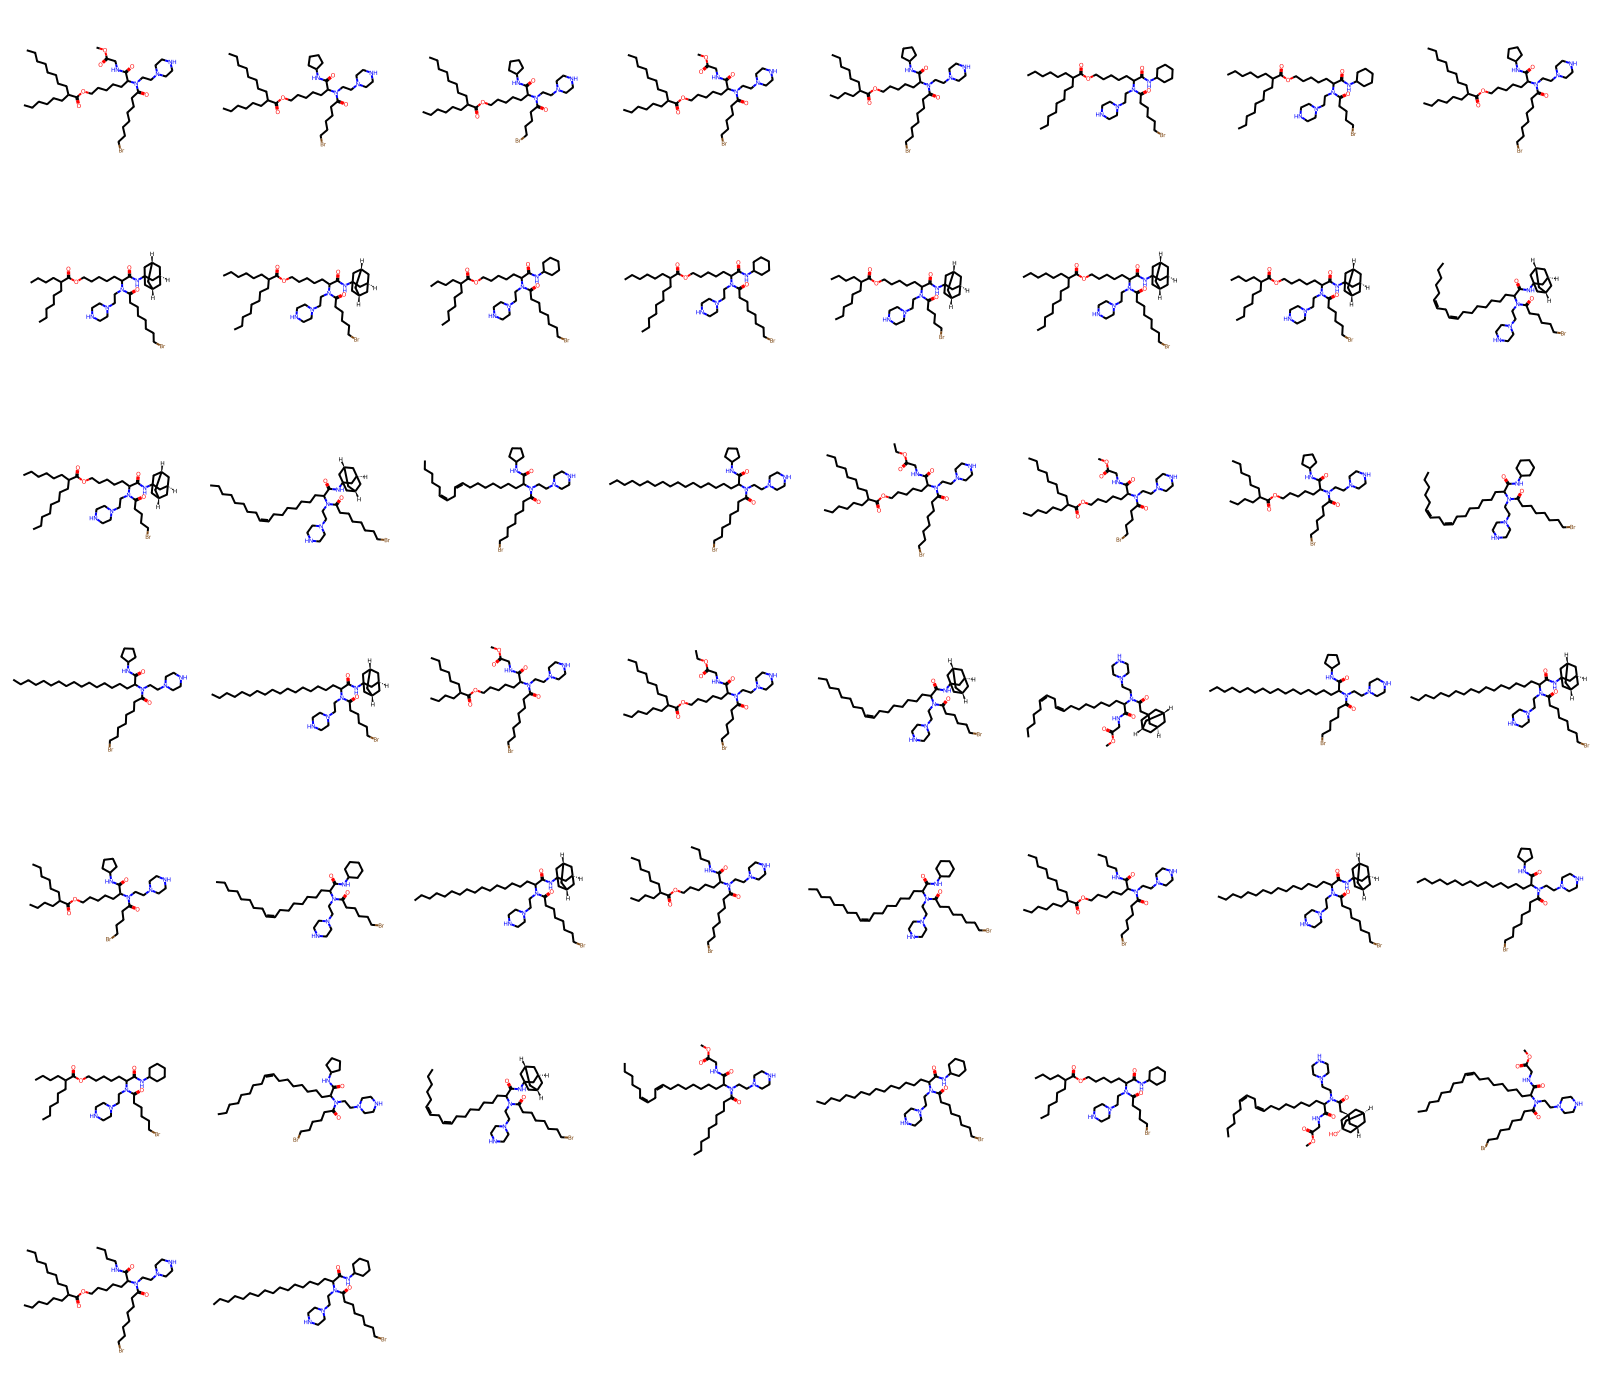

In [6]:
top_96_best = mean_pred_res.mean(axis=1).sort_values(ascending=False).head(96).index

# get structures for the selected points


import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

# draw the structures, structures is a list of smiles
mols = [Chem.MolFromSmiles(smi) for smi in top_96_best]

Draw.MolsToGridImage(mols, molsPerRow=8, subImgSize=(200, 200))

In [7]:
_, count_table = count_components(top_96_best)
count_table.head()

reagent_name  count
0                 A0304     96
1  8-bromooctanoic acid     32
2  6-bromohexanoic acid     25
3                 C2959     24
4                 I0824     23

In [8]:
smiles = mean_pred_res.index[3]
components_row = mapping_df[mapping_df["combined_mol_SMILES"] == smiles]
components = [
            components_row["A_name"].values[0],
            components_row["B_name"].values[0],
            components_row["C_name"].values[0],
            components_row["D_name"].values[0],
        ]
components

['D0742', 'T1054', 'H1461', 'U0054']

In [9]:
import plotly.express as px
from collections import Counter

def count_combination(structures):
    res_list = []
    # structures is a list of smiles
    idx = mapping_df.index[mapping_df["combined_mol_SMILES"].isin(structures)].tolist()
    A = mapping_df.loc[idx, "A_name"]
    B = mapping_df.loc[idx, "B_name"]
    C = mapping_df.loc[idx, "C_name"]
    D = mapping_df.loc[idx, "D_name"]
    
    for a, b, c, d in zip(A, B, C, D):
        res_list.append([a, b, c, d])
    # count table for each unique A or unqiue B or unique C or unique D
    return res_list

def plot_sankey(structures):
    data = count_combination(structures)
    counter = Counter(tuple(x) for x in data)
    df = pd.DataFrame(counter.items(), columns=["combination", "count"])
    df["A"] = df["combination"].apply(lambda x: x[0])
    df["B"] = df["combination"].apply(lambda x: x[1])
    df["C"] = df["combination"].apply(lambda x: x[2])
    df["D"] = df["combination"].apply(lambda x: x[3])


    
    fig = px.parallel_categories(df, dimensions=["A", "B", "C", "D"],)
    return fig


def select_topk_with_max_repeat(
    k,
    query_idx,
    mapping_df,
    mean_pred_res,
    max_repeat=35,
    existing_component_counts=None,
    smiles_to_skip: Optional[List[str]] = None,
):
    """
    Args:
        k (int): Number of items to select.
        query_idx (list): List of indices to consider for selection.
        mapping_df (DataFrame): DataFrame containing component information.
        mean_pred_res (DataFrame): DataFrame containing prediction results.
        max_repeat (int): Maximum allowed count for any component.
        existing_component_counts (dict): Existing counts of components.
        smiles_to_skip (list): List of SMILES strings to skip.
    """
    
    component_counts = {}
    if existing_component_counts is not None:
        component_counts = existing_component_counts

    sample_res = []
    for i, idx in enumerate(query_idx):
        if len(sample_res) >= k:
            break

        # get the SMILES string for the selected index
        smiles = mean_pred_res.index[idx]
        # skip if the SMILES is in the list of SMILES to skip
        if smiles_to_skip is not None and smiles in smiles_to_skip:
            continue

        # find the components in mapping_df
        components_row = mapping_df[mapping_df["combined_mol_SMILES"] == smiles]
        components = [
            components_row["A_name"].values[0],
            components_row["B_name"].values[0],
            components_row["C_name"].values[0],
            components_row["D_name"].values[0],
        ]

        # check if adding this sample would exceed the max_repeat for any component
        if any(component_counts.get(comp, 0) + 1 > max_repeat for comp in components):
            continue

        # update component counts
        for comp in components:
            component_counts[comp] = component_counts.get(comp, 0) + 1

        # add the index to the result
        sample_res.append(idx)
        print(f"Selected {len(sample_res)} after {i+1} iterations.")

    return sample_res, component_counts


In [10]:
plot_sankey(top_96_best)

# step 2

In [11]:
df = mean_embeddings
# to float32
df = df.astype(np.float32)

# NOTE: mapping_df and mean_embeddings have DIFFERENT order


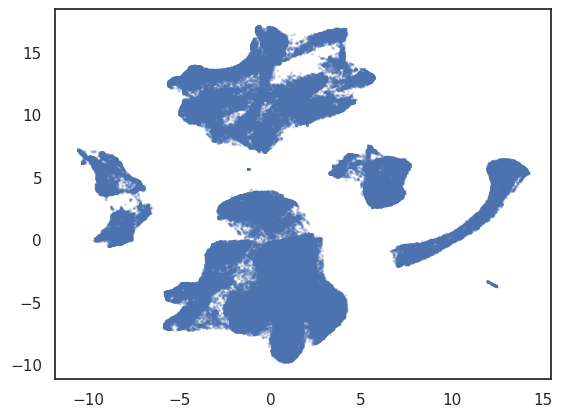

In [12]:
# plot umap and save coordinates
umap_embedding_cache = "/home/sdl/SDL-LNP/model/evaluation/notebooks/umap_coordinates.npy"

if os.path.exists(umap_embedding_cache):
    umap_embedding = np.load(umap_embedding_cache)
else:
    umap = UMAP()
    umap_embedding = umap.fit_transform(df)
    np.save(umap_embedding_cache, umap_embedding)

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], alpha=0.2, s=1)


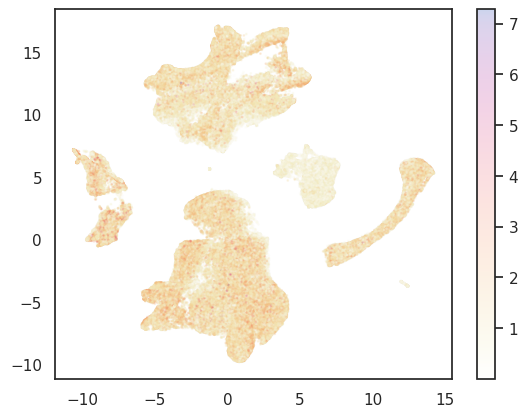

In [13]:
# plot umap

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], alpha=0.2, s=1, 
            c = predictive_variance, cmap=cc.cm.CET_L17,)
# show bar
plt.colorbar()

<Axes: >

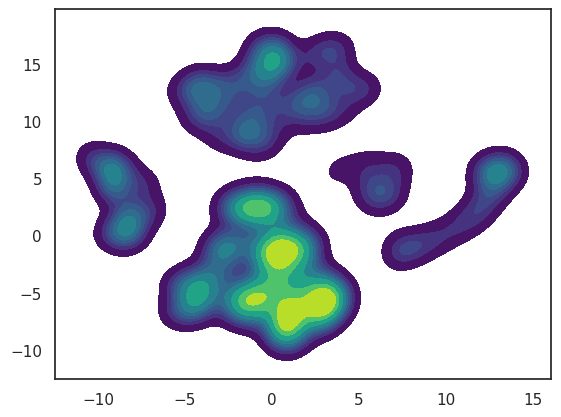

In [14]:
# kde weight by predictive variance

sns.kdeplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], fill=True, cmap="viridis", 
            weights=predictive_variance)

<Axes: >

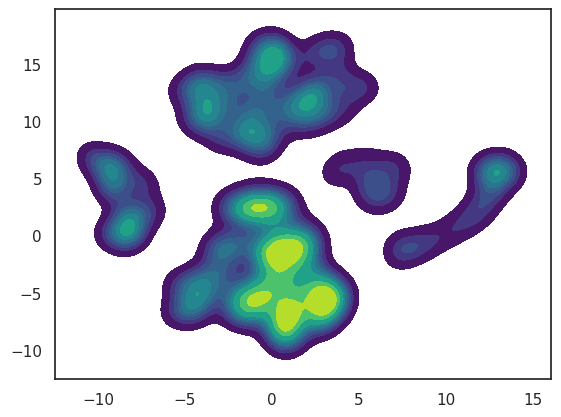

In [15]:
# weight by pred result

agg_pred_res = mean_pred_res.mean(axis=1)  # TODO: the aggregation can be updated, in consideration that the prediction scales can be different

# normalize
agg_pred_res = (agg_pred_res - agg_pred_res.min()) / (agg_pred_res.max() - agg_pred_res.min())
sns.kdeplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], fill=True, cmap="viridis", weights=agg_pred_res)

# step 3

In [16]:
# predicted efficacy first sampling
N=30000
query_index = mean_pred_res.mean(axis=1).reset_index().sort_values(ascending=False,by=0).head(N).index
efficacy_diversity_sample_idx, component_counts = select_topk_with_max_repeat(
    184,
    query_index,
    mapping_df,
    mean_pred_res,
    max_repeat=35,
)

Selected 1 after 1 iterations.
Selected 2 after 2 iterations.
Selected 3 after 3 iterations.
Selected 4 after 4 iterations.
Selected 5 after 5 iterations.
Selected 6 after 6 iterations.
Selected 7 after 7 iterations.
Selected 8 after 8 iterations.
Selected 9 after 9 iterations.
Selected 10 after 10 iterations.
Selected 11 after 11 iterations.
Selected 12 after 12 iterations.
Selected 13 after 13 iterations.
Selected 14 after 14 iterations.
Selected 15 after 15 iterations.
Selected 16 after 16 iterations.
Selected 17 after 17 iterations.
Selected 18 after 18 iterations.
Selected 19 after 19 iterations.
Selected 20 after 20 iterations.
Selected 21 after 21 iterations.
Selected 22 after 22 iterations.
Selected 23 after 23 iterations.
Selected 24 after 24 iterations.
Selected 25 after 25 iterations.
Selected 26 after 26 iterations.
Selected 27 after 27 iterations.
Selected 28 after 28 iterations.
Selected 29 after 29 iterations.
Selected 30 after 30 iterations.
Selected 31 after 31 iterati

In [17]:
efficacy_diversity_sampled_df = df.iloc[efficacy_diversity_sample_idx]
structures = efficacy_diversity_sampled_df.index
plot_sankey(structures)

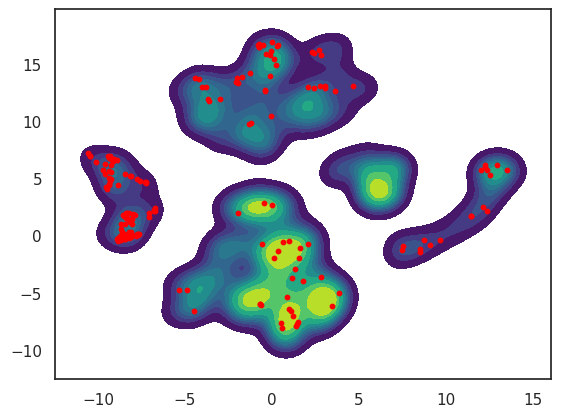

In [18]:
ax = sns.kdeplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], fill=True, cmap="viridis")

# overlay the selected points
ax.scatter(umap_embedding[efficacy_diversity_sample_idx, 0], umap_embedding[efficacy_diversity_sample_idx, 1], s=10, c="red")

In [19]:
all_selected_idx = efficacy_diversity_sample_idx
structures = df.iloc[all_selected_idx].index


In [20]:
# get the selected structures in mapping_df
# idx = mapping_df.index[mapping_df["combined_mol_SMILES"].isin(structures)].tolist()
# structures_df = mapping_df.loc[idx].reset_index(drop=True)
# need to make sure the order keeps the same
idx = []
for smi in structures:
    idx.append(mapping_df[mapping_df["combined_mol_SMILES"] == smi].index[0])
structures_df = mapping_df.loc[idx].reset_index(drop=True)

In [21]:
structures_df

id                                combined_mol_SMILES  \
0     22762  CCCCCCCCC(CCCCCC)C(=O)OCCCCCC(C(=O)NCC(=O)OC)N...   
1     23913  CCCCCCCCC(CCCCCC)C(=O)OCCCCCC(C(=O)NC1CCCC1)N(...   
2     23912  CCCCCCCCC(CCCCCC)C(=O)OCCCCCC(C(=O)NC1CCCC1)N(...   
3     22761  CCCCCCCCC(CCCCCC)C(=O)OCCCCCC(C(=O)NCC(=O)OC)N...   
4     23950  CCCCCCC(CCCC)C(=O)OCCCCCC(C(=O)NC1CCCC1)N(CCN1...   
..      ...                                                ...   
179  134028  CCCCCCCCCCCCCCCC(C(=O)NCC(=O)OCC)N(C(=O)CC12C[...   
180    2700  CCCCCCCCCCCCCCCC(C(=O)NCC(=O)OCC)N(CCN(C)C)C(=...   
181    2701  CCCCCCCCCCCCCCCC(C(=O)NCC(=O)OCC)N(CCN(C)C)C(=...   
182  133837  CCCCCCCC/C=C\CCCCCCCC(=O)N(C1CCC(N(C)C)CC1)C(C...   
183    2762  CCCCC/C=C\C/C=C\CCCCCCCC(=O)N(CCN(C)C)C(CCCCCC...   

             A_smiles            B_smiles                         C_smiles  \
0         NCCN1CCNCC1   COC(C[N+]#[C-])=O  O=C(C(CCCCCCCC)CCCCCC)OCCCCCC=O   
1         NCCN1CCNCC1    [C-]#[N+]C1CCCC1  O=C(C(CCCCCCCC)CCCCCC)OCCCCCC=O   
2         NCCN1CCNCC1    [C-]#[N+]C1CCCC1  O=C(C(CCCCCCCC)CCCCCC)OCCCCCC=O   
3         NCCN1CCNCC1   COC(C[N+]#[C-])=O  O=C(C(CCCCCCCC)CCCCCC)OCCCCCC=O   
4         NCCN1CCNCC1    [C-]#[N+]C1CCCC1      CCCCCCC(CCCC)C(OCCCCCC=O)=O   
..                ...                 ...                              ...   
179  NC(CC1)CCC1N(C)C  O=C(C[N+]#[C-])OCC               CCCCCCCCCCCCCCCC=O   
180          NCCN(C)C  O=C(C[N+]#[C-])OCC               CCCCCCCCCCCCCCCC=O   
181          NCCN(C)C  O=C(C[N+]#[C-])OCC               CCCCCCCCCCCCCCCC=O   
182  NC(CC1)CCC1N(C)C  O=C(C[N+]#[C-])OCC                   CCCCCCCCCCCC=O   
183          NCCN(C)C  O=C(C[N+]#[C-])OCC              CCCCCCCCCCCCCCCCC=O   

                                          D_smiles A_name B_name  \
0                                  O=C(O)CCCCCCCBr  A0304  M2549   
1                                    O=C(O)CCCCCBr  A0304  C2959   
2                                     O=C(O)CCCCBr  A0304  C2959   
3                                    O=C(O)CCCCCBr  A0304  M2549   
4                                  O=C(O)CCCCCCCBr  A0304  C2959   
..                                             ...    ...    ...   
179       OC(CC(C1)(C2)C[C@@H]3C[C@H]2C[C@H]1C3)=O  D4288  I0562   
180       OC(CC(C1)(C2)C[C@@H]3C[C@H]2C[C@H]1C3)=O  D5616  I0562   
181  OC(C[C@@](C1)(C2)C[C@]3(O)C[C@H]2C[C@H]1C3)=O  D5616  I0562   
182                     CCCCCCCC/C=C\CCCCCCCC(O)=O  D4288  I0562   
183                  CCCCC/C=C\C/C=C\CCCCCCCC(O)=O  D5616  I0562   

                   C_name                 D_name  
0    2-butyloctanoic acid   8-bromooctanoic acid  
1    2-butyloctanoic acid   6-bromohexanoic acid  
2    2-butyloctanoic acid  5-bromopentanoic acid  
3    2-butyloctanoic acid   6-bromohexanoic acid  
4    2-hexyldecanoic acid   8-bromooctanoic acid  
..                    ...                    ...  
179                 H0071                  A0736  
180                 H0071                  A0736  
181                 H0071                  H1414  
182                 D0979                  O0190  
183                 H0018                  L0124  

[184 rows x 10 columns]

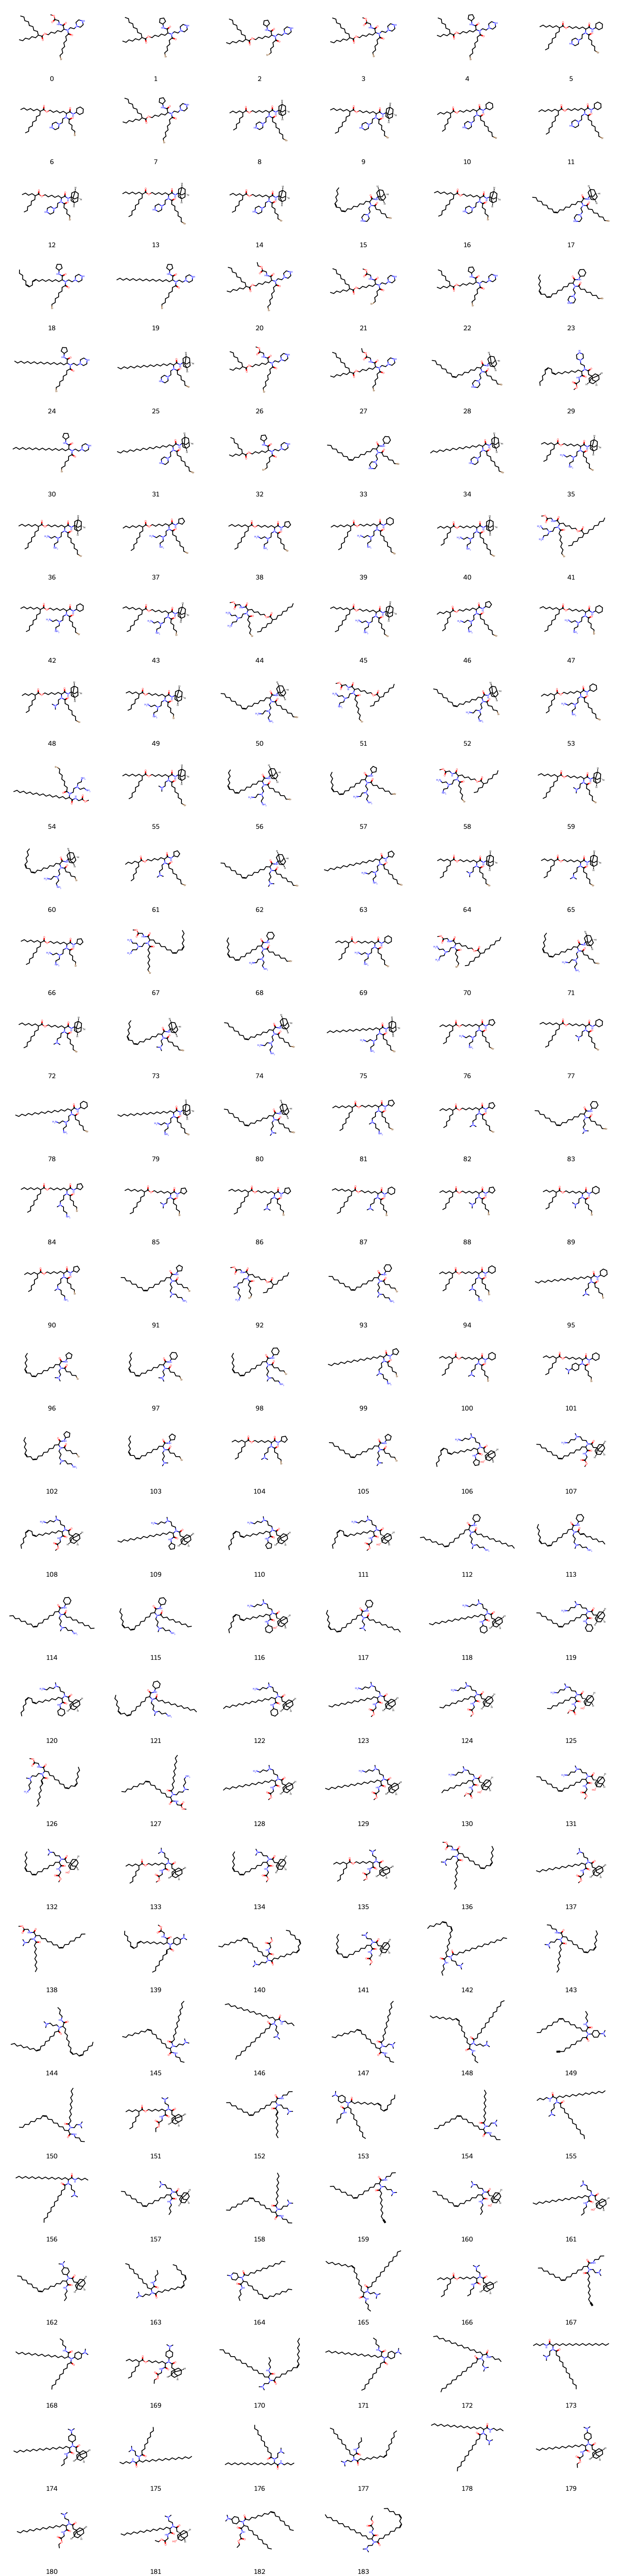

In [22]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

structures = structures_df["combined_mol_SMILES"].values

# draw the structures, structures is a list of smiles
mols = [Chem.MolFromSmiles(smi) for smi in structures]

Draw.MolsToGridImage(mols, molsPerRow=6, subImgSize=(250, 200), legends=[f"{i}" for i in range(len(mols))], maxMols=len(mols))

In [23]:
structures_df.to_csv("./selected_structures_exp9.csv", index=False)

In [24]:
# next step: run model/active_learning/convert_to_experiment_input.ipynb